In [1]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.sensor import TeledyneCMOS, TCMOS_test
from pyeosim.postprocess import CmosReflectance
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb
from pyeosim.measure import NDVI
from sklearn import linear_model

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))

In [59]:
im.shape

(186, 362, 362)

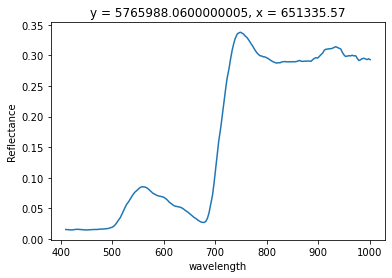

In [62]:
(im.isel(x=180, y=200)/10000).plot()

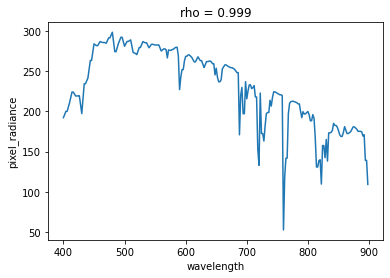

In [4]:
(atmos.LUT.sel(rho=1, method='nearest')*1000).plot()

In [5]:
cmos_16 = TCMOS_test(store_steps=False,
                    TDI_rows=16,
                    lens_diameter=.25,
                    pix_per_row=8196,
                    sense_node_gain=50,
                     dark_current=570/32,
                    adc_vref=1.6,
                     dark_factor=0,
                     prnu_factor=0,
                     offset_factor=0)

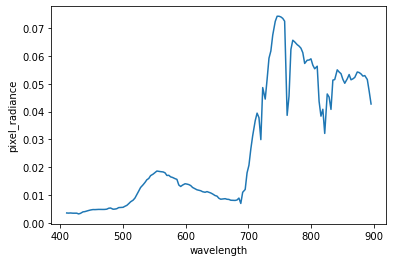

In [6]:
TOA_bands = cmos_16.spectral_response.transform(TOA)
TOA_ndvi = (TOA_bands.isel(band=9) - TOA_bands.isel(band=5))/(TOA_bands.isel(band=9) + TOA_bands.isel(band=5))
TOA_veg_median = TOA.where(TOA_ndvi > 0).median(['x','y'])
TOA_veg_median.plot()

In [33]:
# Use the vegetation median signal to generate as a percentage (1% - 200%)
_ar = np.atleast_2d(np.linspace(.01,2,200)).T * TOA_veg_median.values
test_array = xarray.DataArray(
    np.broadcast_to(np.atleast_3d(_ar), (200, 153, 10000)),
    coords=[('y', np.linspace(.01,2,200)),
             ('wavelength', TOA.wavelength),
             ('x', np.arange(10000))]).transpose('y', 'x',...)

In [45]:
cmos_16 = TCMOS_test(store_steps=True,
                    TDI_rows=16,
                    lens_diameter=.25,
                    pix_per_row=8196,
                    sense_node_gain=50,
                     dark_current=570/32,
                    adc_vref=1.6,
                     dark_factor=0,
                     prnu_factor=0,
                     offset_factor=0)
test_output_16 = cmos_16.fit_transform(test_array)
median_photons_16 = cmos_16.step_outputs['add photon shot noise'].isel(y=100).mean('x')
median_electrons_16 = cmos_16.step_outputs['photon to electron'].isel(y=100).mean('x')

In [46]:
params = cmos_16.get_params()
for i in ['spectral_response','Q_E', 'column_offset_FPN', 'PRNU', 'DSNU']:
    params.pop(i)

In [47]:
band_radiances = cmos_16.spectral_response.transform(test_array)# in microns-1

In [48]:
cmos_32 = TCMOS_test(store_steps=True,
                    TDI_rows=32,
                    lens_diameter=.25,
                    pix_per_row=8196,
                    sense_node_gain=50,
                     dark_current=570/32,
                    adc_vref=1.6,
                     dark_factor=0,
                     prnu_factor=0,
                     offset_factor=0)
test_output_32 = cmos_32.fit_transform(test_array)
median_photons_32 = cmos_32.step_outputs['add photon shot noise'].isel(y=100).mean('x')
median_electrons_32 = cmos_32.step_outputs['photon to electron'].isel(y=100).mean('x')

In [49]:
median_electrons_16

<xarray.DataArray (band: 10)>
array([  590.0338,  1648.751 ,   830.471 ,  3196.565 ,  1976.924 ,
        2736.4564,  2984.4571,  9999.7677,  8899.6055, 11883.7157])
Coordinates:
    y          float64 1.01
  * band       (band) int64 0 1 2 3 4 5 6 7 8 9
    band_name  (band) <U13 'Clouds' 'Carotenoids' 'PRI_1' ... 'RedEdge_3' 'NIR'

In [50]:
SNR = test_output_16.mean('x')/test_output_16.std('x')
SNR = SNR.swap_dims({'band':'band_name'})
median_vegetation_SNR_16 = SNR.isel(y=100).to_pandas()
median_vegetation_SNR_16

band_name
Clouds            19.689691
Carotenoids       37.823780
PRI_1             24.153035
PRI_2             56.150789
Chlorophyll_1     41.511331
Chlorophyll_2     50.644201
RedEdge_1         53.350104
RedEdge_2        105.597160
RedEdge_3        104.130853
NIR              149.554649
dtype: float64

In [51]:
SNR = test_output_32.mean('x')/test_output_32.std('x')
SNR = SNR.swap_dims({'band':'band_name'})
median_vegetation_SNR_32 = SNR.isel(y=100).to_pandas()
median_vegetation_SNR_32

band_name
Clouds            31.265612
Carotenoids       57.368240
PRI_1             38.519499
PRI_2             82.363609
Chlorophyll_1     62.562313
Chlorophyll_2     74.093670
RedEdge_1         79.440122
RedEdge_2        150.429063
RedEdge_3        151.406721
NIR              216.151685
dtype: float64

In [52]:
SNR = (test_output_32 + test_output_16).mean('x')/(test_output_32 + test_output_16).std('x')
SNR = SNR.swap_dims({'band':'band_name'})
median_vegetation_SNR_32_16 = SNR.isel(y=100).to_pandas()
median_vegetation_SNR_32_16

band_name
Clouds            36.717566
Carotenoids       68.909126
PRI_1             45.306857
PRI_2            100.300475
Chlorophyll_1     75.273548
Chlorophyll_2     89.476837
RedEdge_1         95.951710
RedEdge_2        185.617396
RedEdge_3        184.339266
NIR              263.239186
dtype: float64

In [53]:
df_ex = pandas.DataFrame([median_vegetation_SNR_16,
 median_vegetation_SNR_32,
 median_vegetation_SNR_32_16]).T
df_ex.columns = ['SNR_16', 'SNR_32', 'SNR_summed']
df_ex = df_ex.astype(int)
df_ex['Total band radiance (W m-2 sr-1)'] = band_radiances.isel(x=0,y=100)
df_ex = df_ex.round(3)
df_ex['Photons_16'] = median_photons_16.values.astype(int)
df_ex['Photons_32'] = median_photons_32.values.astype(int)
df_ex['Photons_summed'] = (median_photons_16.values + median_photons_32.values).astype(int)

df_ex['Electrons_16'] = median_electrons_16.values.astype(int)
df_ex['Electrons_32'] = median_electrons_32.values.astype(int)
df_ex['Electrons_summed'] = (median_electrons_16.values + median_electrons_32.values).astype(int)

In [43]:
df_ex


,SNR_16,SNR_32,SNR_summed,Total band radiance (W m-2 sr-1),Photons_16,Photons_32,Photons_summed,Electrons_16,Electrons_32,Electrons_summed
band_name,,,,,,,,,,
Clouds,19,31,37,0.086,686,1373,2060,589,1179,1769
Carotenoids,38,57,68,0.209,1847,3697,5544,1648,3299,4948
PRI_1,24,38,45,0.096,920,1841,2762,830,1662,2493
PRI_2,56,81,100,0.350,3530,7061,10591,3196,6392,9589
Chlorophyll_1,42,62,74,0.193,2146,4294,6441,1977,3955,5932
Chlorophyll_2,50,74,89,0.250,2983,5966,8950,2736,5473,8210
RedEdge_1,54,78,95,0.264,3327,6654,9981,2983,5966,8950
RedEdge_2,105,150,183,0.884,11760,23516,35276,10001,19999,30001
RedEdge_3,103,151,182,0.833,11695,23386,35081,8900,17798,26698
